Measuring of Urbanity
===================

In this notebook, we define a measure of urbanity for municipalities. First, we produce a composite score based the *Tranche d'aire urbaine* and *zonage en aire urbaine* in which the municipalities is located. Then, we take municipalities that belong to a larger *Tranches d'aires urbaines* of less than 100'000 inhabitants, and measure their distance to the nearest larger *Tranche d'aire urbaine*. Finally, we score these remaining municipalities according to a series of distance thresholds.

# 1 — General Commands

In [99]:
import requests
import pathlib
import urllib.request
import zipfile
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 2 — Input data

## 2.1 — Geo data

### 2.1.1. — France municipalities

First, we input municipal borders in metropolitan France from *data.gouv.fr*.

In [100]:
""" Metropolitan France municipal geographical boundaries
    Dataset name: Communes France métropole 
    Data provider: data.gouv.fr
    Location (permalink): https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c
"""
url = 'https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c'
communes = gpd.read_file(url)
communes = communes.to_crs('epsg:2154')
communes.head()

gml_id   CODE                  LIBELLE  \
0  COMMUNE.01001  01001  L'ABERGEMENT-CLEMENCIAT   
1  COMMUNE.01002  01002    L'ABERGEMENT-DE-VAREY   
2  COMMUNE.01004  01004        AMBERIEU-EN-BUGEY   
3  COMMUNE.01005  01005      AMBERIEUX-EN-DOMBES   
4  COMMUNE.01006  01006                  AMBLEON   

                                            geometry  
0  MULTIPOLYGON (((851129.600 6563369.200, 851107...  
1  MULTIPOLYGON (((888109.700 6545455.900, 888077...  
2  MULTIPOLYGON (((886593.000 6540886.000, 886567...  
3  MULTIPOLYGON (((850413.200 6544061.000, 850356...  
4  MULTIPOLYGON (((899820.100 6520340.200, 900065...

To check if the geodata is coherent with what we want, and to verify the projection, we plot the geometries. 

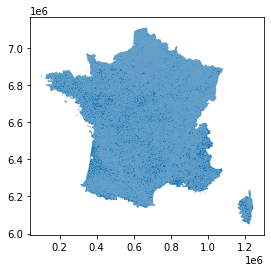

In [101]:
""" Plot France municipal geographical boundaries """
communes.plot()

### 2.1.2 France territory

In [102]:
""" Metropolitan France geographical boundaries
    Dataset name: France 
    Data provider: 
    Location (permalink): https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson
"""
url = 'https://opendata.arcgis.com/datasets/622c243da54e48fea23f8eb92e875c77_77.geojson'
france = gpd.read_file(url)
france = france.to_crs('epsg:2154')

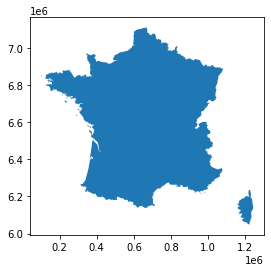

In [103]:
france.plot()

## 2.2 — Urban Areas

Second, we input data from INSEE about urban areas.

> Une aire urbaine ou "grande aire urbaine" est un ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle urbain (unité urbaine) de plus de 10 000 emplois, et par des communes rurales ou unités urbaines (couronne périurbaine) dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Le zonage en aires urbaines 2010 distingue également :

> * les "moyennes aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 5 000 à 10 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.
> * les "petites aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 1 500 à 5 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Les aires urbaines, datées de 2010, ont été établies en référence à la population connue au recensement de 2008.

Source: INSEE. *Base des aires urbaines*. Online: https://www.insee.fr/fr/information/2115011. 

### 2.2.1 — Input *Tranches d'aires urbaines*

INSEE ranks *Tranches d'aires urbaines* into 11 levels: 

* 00: Commune hors aire urbaine
* 01: Commune appartenant à une aire urbaine de moins de 15 000 habitants
* 02: Commune appartenant à une aire urbaine de 15 000 à 19 999 habitants
* 03: Commune appartenant à une aire urbaine de 20 000 à 24 999 habitants
* 04: Commune appartenant à une aire urbaine de 25 000 à 34 999 habitants
* 05: Commune appartenant à une aire urbaine de 35 000 à 49 999 habitants
* 06: Commune appartenant à une aire urbaine de 50 000 à 99 999 habitants
* 07: Commune appartenant à une aire urbaine de 100 000 à 199 999 habitants
* 08: Commune appartenant à une aire urbaine de 200 000 à 499 999 habitants
* 09: Commune appartenant à une aire urbaine de 500 000 à 9 999 999 habitants
* 10: Commune appartenant à l'aire urbaine de Paris 

We use two tables (sheets) from the file. We first input the list of  from an INSEE spreedsheet. In the table, we find four variable:

* **AU2010**: INSEE code of the *aire urbaine* as defined in 2010;
* **LIBAU2010**: label of this *aire urbaine*;
* **TAU2017**: *Tranche d'aire urbaine* as defined in 2017; and 
* **NB_COM**: number of municipalities included in the *aire urbaine*.

In [104]:
""" List Urban Areas
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Information: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
urban_areas = pd.read_excel(f, sheet_name='AU2010', header=5)
urban_areas.head()

AU2010                                  LIBAU2010  TAU2017  NB_COM
0    000  Communes isolées hors influence des pôles        0    7006
1    001                                      Paris       10    1751
2    002                                       Lyon        9     498
3    003                Marseille - Aix-en-Provence        9      90
4    004                                   Toulouse        9     452

In [324]:
au2010_to_codgeo = ua_communes.set_index('AU2010')['CODGEO'].to_dict()
au2010_to_tau2017 = urban_areas.set_index('AU2010')['TAU2017'].to_dict()

In [340]:
""" Create objects to convert TAU2017 variable to other variables """
tau2017_codgeo = pd.concat([ua_communes['AU2010'].replace(au2010_to_tau2017).rename('TAU2017'), ua_communes['CODGEO']], axis=1)
tau2017_to_codgeo = tau2017_codgeo.set_index('TAU2017').to_dict()
tau2017_municipalities = tau2017_codgeo.groupby('TAU2017')['CODGEO'].apply(list)

From this table, we look how many *Tranches d'aires urbaines* exist, how many *aires urbaines* exist, and how many municipalities belong to an *Aire urbaine*.

In [105]:
""" Number of geographical units """
pd.DataFrame.from_dict({"Urban areas":urban_areas.shape[0],
"Tranches d'aire urbaine":len(urban_areas['TAU2017'].unique()),
"Municipalities":urban_areas['NB_COM'].sum()}, orient='index', columns=['Count'])

Count
Urban areas                793
Tranches d'aire urbaine     11
Municipalities           34968

We also look at how many municipalities are situated in each urabn area rank. This gives us an idea of the importance of each rank in terms of area.

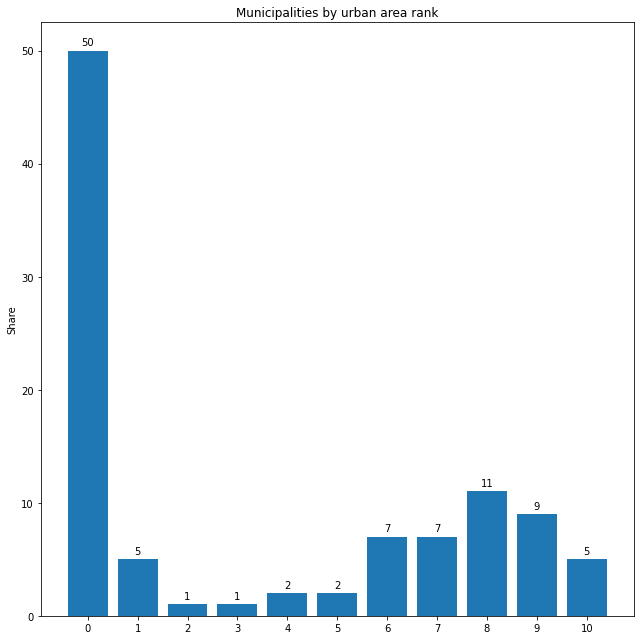

In [213]:
""" Share of municipalities by Tranche d'aire urbaine """
data = pd.DataFrame(urban_areas.groupby('TAU2017')['NB_COM'].sum() / urban_areas['NB_COM'].sum())

# Convert values to percentage integers
data = data.apply(lambda x: round(x, 2)*100)
data['NB_COM'] = data['NB_COM'].astype(int)

# Plot share of municipalities
labels = [str(x) for x in data.index]
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(9,9))
rects1 = ax.bar(x, data.values.ravel(), width, label='Share municipalities')

ax.set_ylabel('Share')
ax.set_title("Municipalities by urban area rank")
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

From this bar plot, we see that most municipalities are outside an urban area (49.67%). Contrary to what could be expected, the share of municipalities in each *Tranche d'aire urbaine* does not follow a *Zipf Law* distribution.

### 2.2.2 — Input *Zonage en aires urbaines*

Second, we input a list of all municipalities and their corresponding classification. In this table, we find five additional variables:

* **CODGEO**: INSEE code of the municipality;
* **LIBGEO**: Name of the municipality;
* **CATAU2010**: INSEE code of the *zone en aire urbaine* as defined in 2010;
* **DEP**: INSEE code of the department in which the municipality is located;
* **REG**: INSEE code of the region in which the municipality is located.

In [106]:
""" List Urban Areas Communes
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Location: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
ua_communes = pd.read_excel(f, sheet_name='Composition_communale', header=5)
ua_communes.head()

CODGEO                   LIBGEO AU2010                       LIBAU2010  \
0  01001  L'Abergement-Clémenciat    997  Multipolarisé des grands pôles   
1  01002    L'Abergement-de-Varey    002                            Lyon   
2  01004        Ambérieu-en-Bugey    002                            Lyon   
3  01005      Ambérieux-en-Dombes    002                            Lyon   
4  01006                  Ambléon    998             Autre multipolarisé   

   CATAEU2010 DEP  REG  
0         120  01   84  
1         112  01   84  
2         112  01   84  
3         112  01   84  
4         300  01   84

In this data, labels for the *Zonage en aire urbaine* (CATAEU2010) are:
* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

Just like we did for urban area ranks, we look at how many municipalities exist in each urabn area zones.

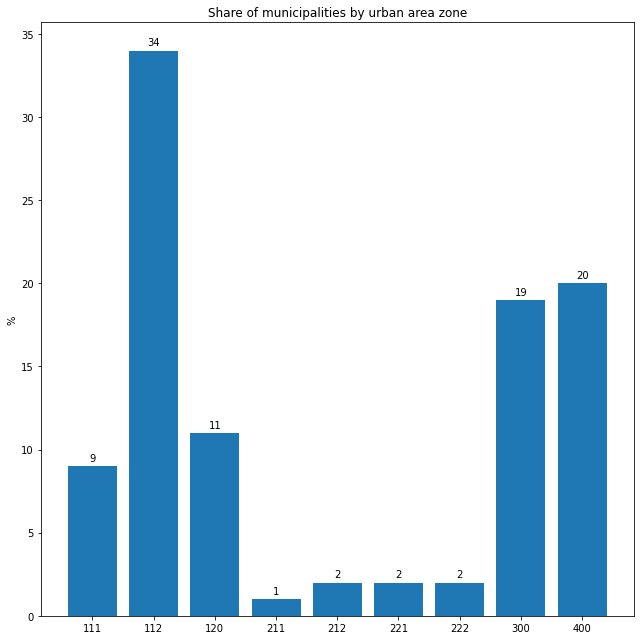

In [215]:
data = ua_communes.groupby('CATAEU2010')['CODGEO'].count() / ua_communes.shape[0]

# Convert values to percentage integers
data = data.apply(lambda x: int(round(x, 2)*100))

# Plot share of municipalities
labels = [str(x) for x in data.index]
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(9,9))
rects1 = ax.bar(x, data.values.ravel(), width, label='Share municipalities')

ax.set_ylabel('%')
ax.set_title("Share of municipalities by urban area zone")
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

### 2.2.3 — Mapping urban area ranks and zones
Using the data we have input, we visualize the geographical distribution of the urban area rank unto a map.

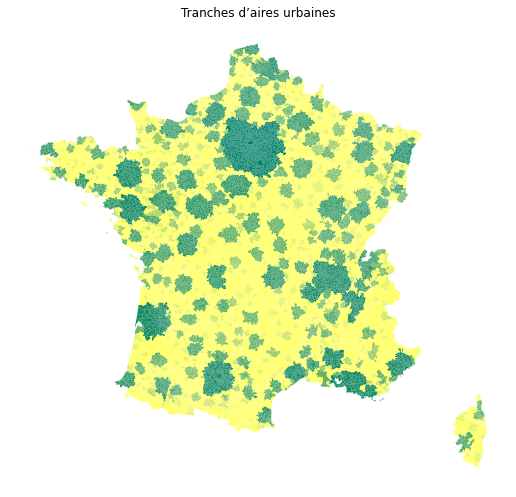

In [216]:
""" Map INSEE's Tranches d'aires urbaines """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
# Create a new variable for TAU2017 by replacing AU2010 through dict
data['TAU2017'] = data['AU2010'].replace(urban_areas.set_index('AU2010')['TAU2017'].to_dict())

data.plot(ax=ax, column='TAU2017', cmap='summer_r')
plt.title('Tranches d’aires urbaines')
ax.axis('off')

plt.show()

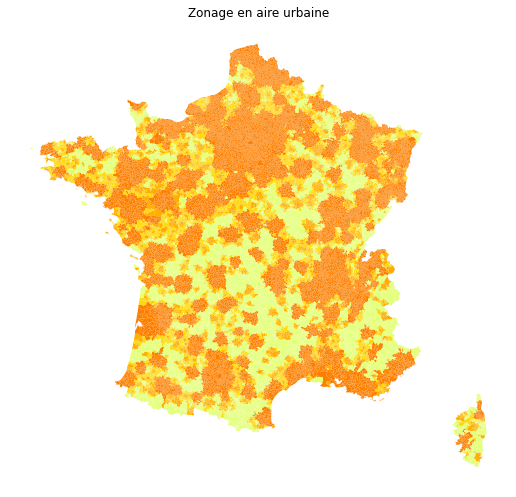

In [217]:
""" Map INSEE's 'Zonage en aires urbaines' """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
data.plot(ax=ax, column='CATAEU2010', cmap='Wistia_r')
plt.title('Zonage en aire urbaine')
ax.axis('off')

plt.show()

The maps above show the *Tranches d'aires urbaines* and the *Zonage en aire urbaine*. The former is a categorical variable with 793 values, while the later is a ordinal variable with 9 values.

## 3 — Measure distance between municipalities and urban area ranks (*tranches d'aires urbaines*)

To measure the distance between every municipality and the nearest urban area rank, we split municipalities in two subsets: those within a given urban area rank and those outside. For example, if we set the threshold to 100'000 inhabitants, we split municipalities that belong to an urban area rank of 100'000 and more, and those that do not.

In [218]:
""" Select municipalities within a 100'000 urban area rank or above """
idx = urban_areas[urban_areas['TAU2017'].isin([7,8,9,10])]['AU2010'].values
in_ua_muni_idx = ua_communes.set_index('AU2010').loc[idx]['CODGEO'].values
in_ua_muni_geo = communes.set_index('CODE').reindex(in_ua_muni_idx).dropna().geometry.values
large_urban_areas = shapely.geometry.MultiPolygon([i for sl in in_ua_muni_geo for i in sl])

idx = urban_areas[urban_areas['TAU2017'].isin([0,1,2,3,4,5,6])]['AU2010'].values
out_ua_muni_idx = ua_communes.set_index('AU2010').loc[idx]['CODGEO'].values
out_ua_muni_geo = communes.set_index('CODE').reindex(out_ua_muni_idx).dropna().geometry

In [219]:
""" Compute distance betwen out municipalities and nearest urban area"""
import os.path
from os import path
# Check first if the data is available locally
f = '../data/koseki-data-distance_to_urban_area_7to10.csv'
if path.exists(f):
    distances = pd.read_csv(f)
     # Rename geometry variable as distance --> change this before output to csv
    distances.columns = ['CODE', 'distance']
else:
    distances = out_ua_muni_geo.apply(lambda x: x.distance(large_urban_areas))
    # Reindex with municipality codes
    distances.set_index('CODE', inplace=True)
    # Rename variable
    distances.name = 'distance'
    
distances.head()

CODE      distance
0  01079  10249.867063
1  01081   1742.371020
2  01187  10230.570720
3  01210      0.000000
4  01247      0.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b8f8a5710>]],
      dtype=object)

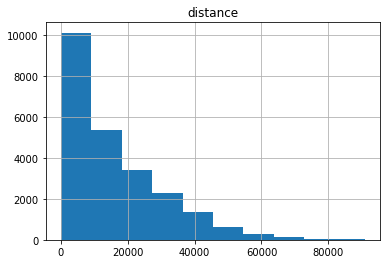

In [220]:
""" Plot distance data """
distances.hist()

In [221]:
""" Output distance data to csv file """
if path.exists(f):
    pass
else:
    distances.to_csv('../data/koseki-data-distance_to_urban_area_7to10.csv')

(41859.01937713251, 1299840.5928409076, 5993068.262450507, 7163751.301226321)

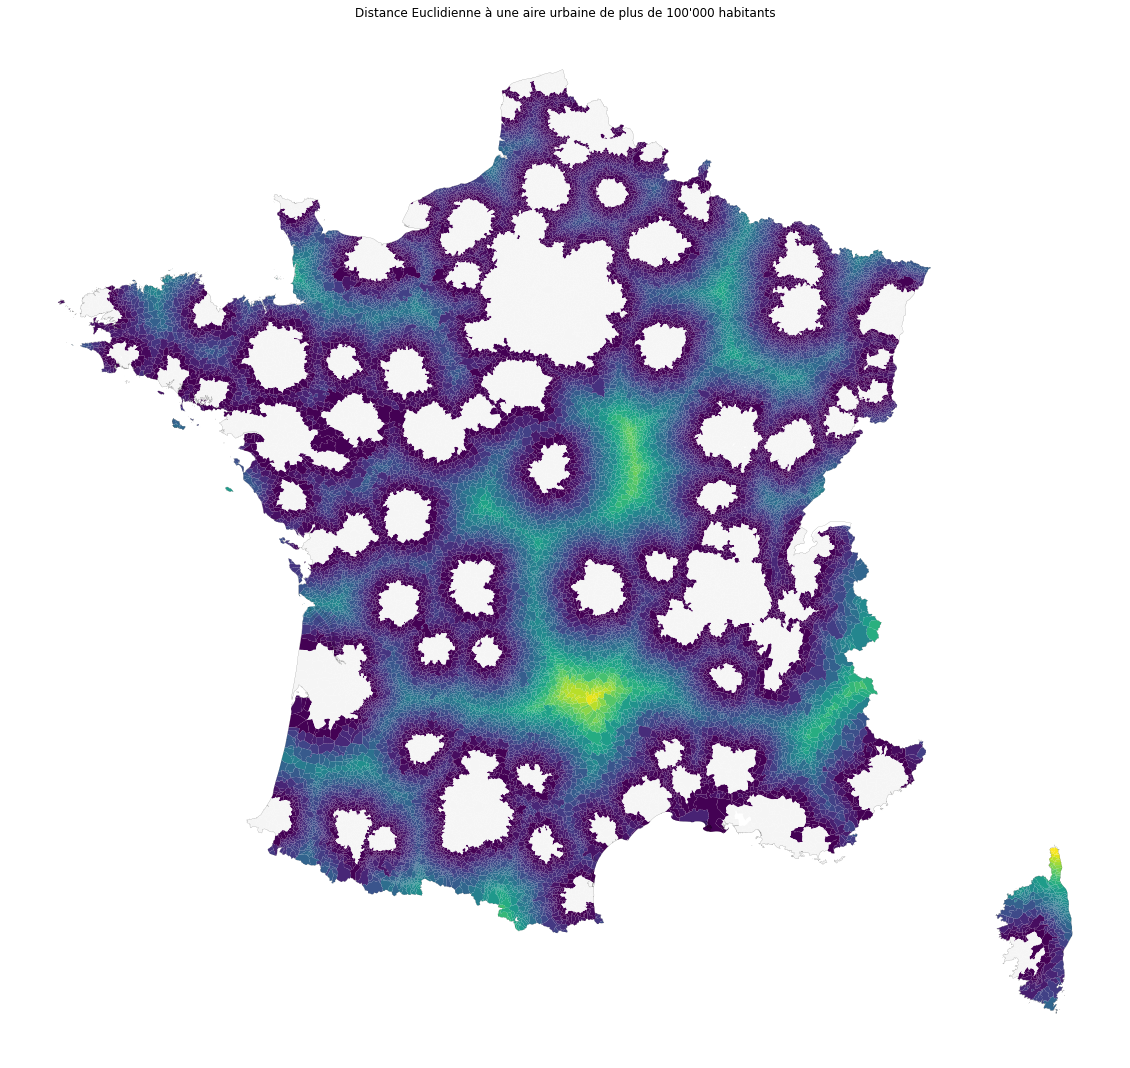

In [222]:
""" Plot map of distance to urban area above 100 k inhabitants """
data = communes.set_index('CODE').join(distances.set_index('CODE'))

fig, ax = plt.subplots(figsize=(20,20))

data.plot(ax=ax, column='distance', cmap='viridis')
# Map urban areas
communes.set_index('CODE').reindex(in_ua_muni_idx).dropna().plot(ax=ax, color='whitesmoke')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1)

plt.title("Distance Euclidienne à une aire urbaine de plus de 100'000 habitants")
ax.axis('off')

# 4 — Urbanity index
Here, we attribute a measure of urbanity for each municipality based on the following score attribution table.
To compute the table's score, we proceed in four steps:
1. Score municipalities according to the size of their urban areas;
2. Score municipalities according to the urban area zoning;
3. Score municipalities outside of urban areas;
4. Score municipalities according to their distance to urban areas of more than 100k inhabitants.

## 4.1 — Set up
Here, we begin by setting up variables and data to properly score municipalities.
First, we split municipalities that are inside or outside of an urban area. To do so, we use the **AU2010** variable, in which municipalities outside of an urban area correspond to the values:
* 000 – *Communes isolées hors influence des pôles*
* 997 – *Multipolarisées des grands pôles*
* 998 – *Autre multipolarisées*

In [223]:
""" Split municipalities in and out of urban areas """
# Municipality urban score series for municipalities outside of an urban area
out_ua_muni_idx = list(ua_communes[ua_communes['AU2010'].isin(['000', '997', '998'])]['CODGEO'])
out_ua_muni_score = pd.DataFrame(data=0, index=list(out_ua_muni_idx), columns=['urban_index'])

# Municipality urban score series for municipalities inside of an urban area
in_ua_muni_idx = list(ua_communes[~ua_communes['AU2010'].isin(['000', '997', '998'])]['CODGEO'])
in_ua_muni_score = pd.DataFrame(data=0, index=list(in_ua_muni_idx), columns=['urban_index'])

## 4.2 — Score municipalities by urban area size

To attribute scores based on the population size of urban areas, we input municipal population data from INSEE.

*In this data, the total population is 57M, which is 10M under 7M under its current 64.81M inhabitants.*

In [4]:
""" Population by urban area
    Dataset name: POP6 – Population de 15 ans ou plus par sexe, âge et catégorie socioprofessionnelle
    Data provider: INSEE.fr
    Data location: https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip
    Information: https://www.insee.fr/fr/statistiques/4171341?sommaire=4171351#consulter
"""
url = 'https://www.insee.fr/fr/statistiques/fichier/4171341/BTT_TD_POP6_2016.zip'
with urllib.request.urlopen(url) as r:
    muni_pop = pd.read_csv(io.BytesIO(r.read()),
                           compression='zip',
                           sep=';',
                           header=0,
                           dtype=str,
                           encoding='latin-1')
muni_pop['NB'] = muni_pop['NB'].astype(float)
muni_pop.head()

NIVGEO CODGEO                        LIBGEO CS1_8 AGEQ65 SEXE   NB
0    ARM  13201  Marseille 1er Arrondissement     1    015    1  0.0
1    ARM  13201  Marseille 1er Arrondissement     1    015    2  0.0
2    ARM  13201  Marseille 1er Arrondissement     1    020    1  0.0
3    ARM  13201  Marseille 1er Arrondissement     1    020    2  0.0
4    ARM  13201  Marseille 1er Arrondissement     1    025    1  0.0

The population data splits the number of inhabitants according to three variables: socioprofessional category (CS1_8), age group (AGEQ65) and gender (SEXE). To get a net population by municipality, we sum corresponding entries.

In [5]:
""" Sum number of people (NB) by municipality (CODGEO) """
muni_pop_sum = muni_pop.groupby('CODGEO')['NB'].sum()
muni_pop_sum.name = 'POP'
muni_pop_sum.head()

CODGEO
01001      605.000000
01002      195.000000
01004    11273.704757
01005     1374.056524
01006       90.000000
Name: POP, dtype: float64

In [226]:
""" Sum population by urban area """
ua_pop =  pd.concat([ua_communes['AU2010'],
                     ua_communes['CODGEO'].replace(muni_pop_sum.to_dict())], axis=1).groupby('AU2010')['CODGEO'].sum()
ua_pop.head()

AU2010
000    2.734915e+06
001    1.010110e+07
002    1.858911e+06
003    1.441580e+06
004    1.101886e+06
Name: CODGEO, dtype: float64

In [227]:
""" Attribute points according to the size of the urban area rank 
    
    Note: This attributes scores to “multipolarized” (997 and 998) and ”isolated” (000) municipalities.
    We shall replace these scores later on.
"""
# Create series to host scores
ua_score = pd.DataFrame(data=0, index=list(ua_communes['CODGEO']), columns=['urban_area_score'])

# Input score table 
f = '../data/koseki-table-urban_area_score.csv'
ua_score_table = pd.read_csv(f)
ua_score_table['range'] = ua_score_table['range'].apply(lambda x: [int(y) for y in x.split(':')])
ua_score_table = ua_score_table.set_index('score').to_dict()['range']

# Compute score by urban area size
for score in ua_score_table:
    t1,t2 = ua_score_table[score]
    # Municipalities that belong to a urban area with given population range
    ua_idx = ua_pop[ua_pop.between(t1, t2, inclusive=True)].index
    # select municpalities corresponding to the urban area index
    muni_idx = list(ua_communes.set_index('AU2010').loc[ua_idx]['CODGEO'])
    ua_score.loc[muni_idx] = ua_score.loc[muni_idx]+score

# Reset scores for multipolarized or isolated municipalities (CATAEU2010 == [120, 300, 400]
ua_score.loc[list(ua_communes[ua_communes['CATAEU2010'].isin([120, 300, 400])]['CODGEO']), 'urban_area_score'] = 0

ua_score.head()

urban_area_score
01001                 0
01002                 2
01004                 2
01005                 2
01006                 0

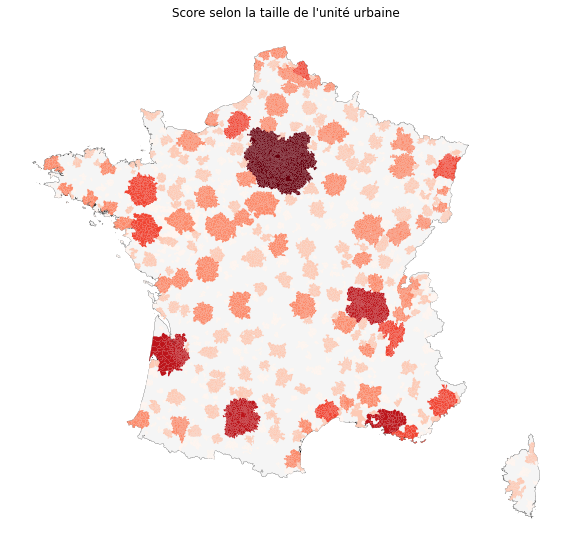

In [228]:
""" Plot map of ua_scores """
data = communes.set_index('CODE').join(ua_score)
data['urban_area_score'] = data['urban_area_score'].replace(0, np.nan)
data.dropna(subset=['urban_area_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

france.plot(ax=ax, facecolor='whitesmoke', edgecolor='k', linewidth=0.2)
data.plot(ax=ax, column='urban_area_score', cmap='Reds_r')


plt.title("Score selon la taille de l'unité urbaine")
ax.axis('off')
plt.show()

## 4.3 — Score municipalities by urban area zoning

Next, we add points according to the municipality's location wihtin an urban area. For this, we rely on the INSEE classification of  municipalities in “Zonage en aire urbaine,” which describres three types of zones: central, first crown and multipolarized. In the data, this corresponds to the “CATAEU2010" variable, which takes up 9 values:

* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

In [107]:
""" Add points according to urban area zoning """
# Create series to host scores
uaz_score = pd.DataFrame(data=np.nan, index=list(ua_communes['CODGEO']), columns=['urban_area_score'])

# score dictionnary based on the CATAEU2010 values --> This shall be transfered to a file
scores = {111:1, 112:2, 211:1, 212:2, 221:1, 222:2, 120:9, 300:9, 400:10}
for zone in scores:
    score = scores[zone]
    muni_idx = list(ua_communes.set_index('CATAEU2010').loc[zone]['CODGEO'])
    uaz_score.loc[muni_idx] = uaz_score.loc[muni_idx]=score
uaz_score.head()

urban_area_score
01001               9.0
01002               2.0
01004               2.0
01005               2.0
01006               9.0

We also want to differenciate between central municpality (the city) and the adjacent areas. The classification in urban area zone does not do this. For example, in the urban area of Paris, INSEE classify the municipality of Paris in the same category of surrounding municipalities of Pantin, Montreuil, Neuilly, etc. 

To reflect the more urban character of central municipalities, we remoce one point to municipalities at the center of the urban area. While the data does not specify the code of those municipalities, we use their name to select them. Indeed, the name of the central municipality corresponds to the name of the urban area.

In [108]:
""" Remove one point if the municipality if the core municipality of the urabn area """
# Select areas in urban poles (large, medium and large)
urban_poles = ua_communes[ua_communes['CATAEU2010'].isin(['111','211'])]
# Select municipalities with the same name as urban area (central municipalities)
muni_idx = urban_poles[urban_poles['LIBGEO']==urban_poles['LIBAU2010']].set_index('CODGEO').index
# Remove score (-1) to these municipalities
score = -1
uaz_score.loc[muni_idx] = uaz_score.loc[muni_idx]+score

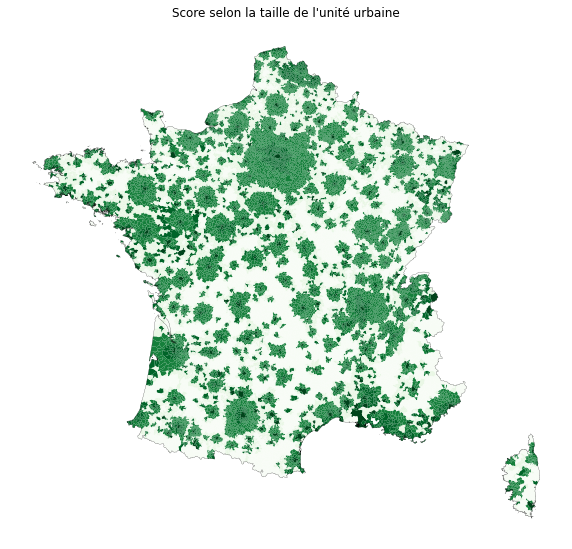

In [109]:
""" Plot map of ua_scores """
data = communes.set_index('CODE').join(uaz_score)
data.dropna(subset=['urban_area_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

data.plot(ax=ax, column='urban_area_score', cmap='Greens_r')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2)

plt.title("Score selon la taille de l'unité urbaine")
ax.axis('off')
plt.show()

## 4.4 — Score municipalities by distance to large urban area

In [232]:
""" Add points for distance to large urban area 

    Add 1 point if distance is between 20 and 50km, and 2 points if above 50km
"""
# Create series to host scores
distance_score = pd.DataFrame(data=0, index=list(ua_communes['CODGEO']), columns=['distance_score'])

# Add score for distance between 20 and 50km
idx = distances[distances['distance'].between(20000, 50000)].set_index('CODE').index
distance_score.loc[idx, 'distance_score'] += 1 

# Add score for distance more than 50km
idx = distances[distances['distance']>50000].set_index('CODE').index
distance_score.loc[idx, 'distance_score'] += 2

distance_score.head()

distance_score
01001               0
01002               0
01004               0
01005               0
01006               0

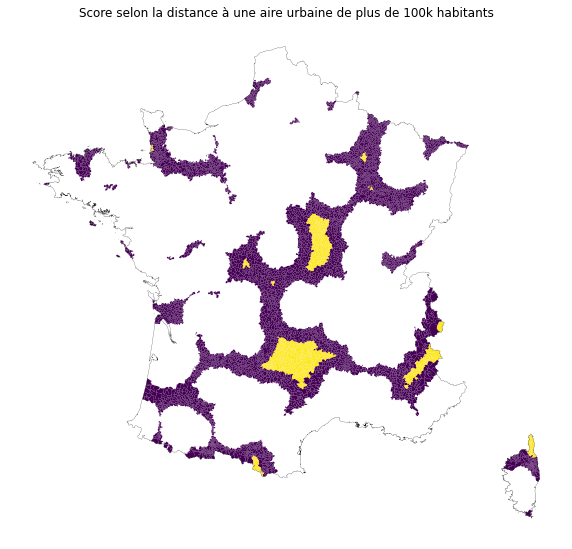

In [233]:
""" Plot map of distance score """
data = communes.set_index('CODE').join(distance_score)
data['distance_score'] = data['distance_score'].replace(0, np.nan)
data.dropna(subset=['distance_score'], inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

data.plot(ax=ax, column='distance_score')
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2)

plt.title("Score selon la distance à une aire urbaine de plus de 100k habitants")
ax.axis('off')
plt.show()

# 4.5 — Compile scores

In [96]:
""" Compile scores """
urban_score = pd.concat([ua_score, uaz_score, distance_score], axis=1).sum(axis=1)
urban_score.name='urban_score'
urban_score.reset_index()
urban_score.columns = ['CODEGEO', 'urban_score']
urban_score.head()

NameError: name 'ua_score' is not defined

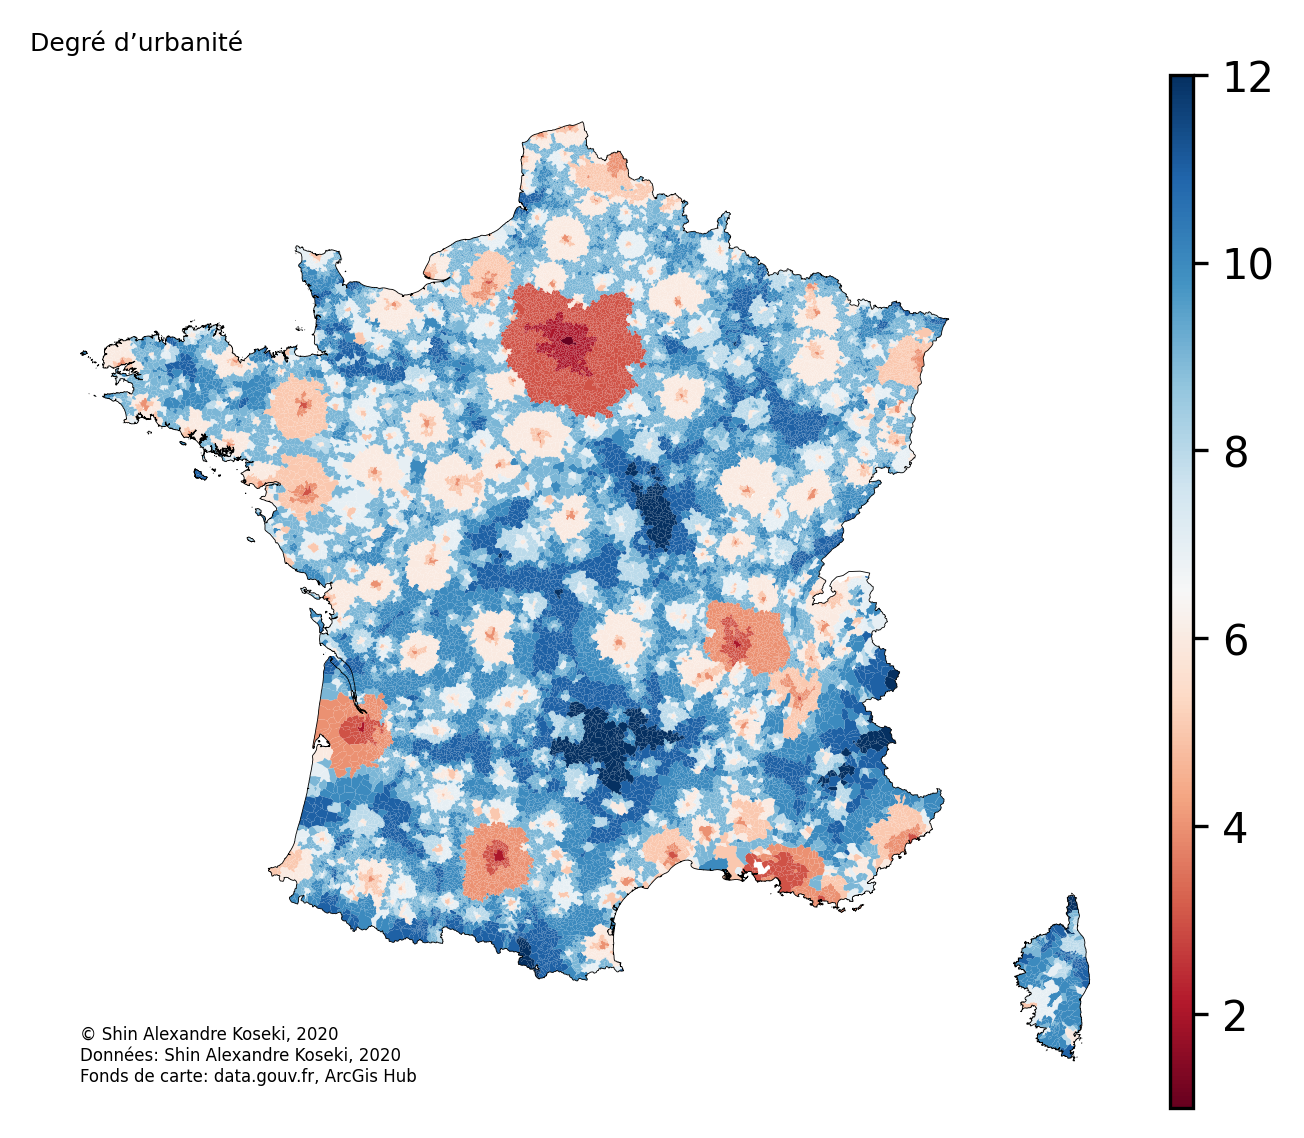

In [236]:
""" Plot map of distance to urban area above 100 k inhabitants """
data = communes.set_index('CODE').join(urban_score.set_index('CODGEO'))
data['urban_score'] = data['urban_score'].replace(0, np.nan)
data.dropna(subset=['urban_score'], inplace=True)

# Init plot
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

# Title
plt.title("Degré d’urbanité", fontsize=6, loc='left')

# Notes
s = """
© Shin Alexandre Koseki, 2020
Données: Shin Alexandre Koseki, 2020
Fonds de carte: data.gouv.fr, ArcGis Hub
"""
ax.text(x=99047.004614, y=6000000, s=s, fontsize=4)

# Legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Plot data
data.plot(ax=ax, column='urban_score', cmap='RdBu', legend=True, cax=cax)
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2)

ax.axis('off')
#plt.savefig('../output/koseki-map-urbanity_measure-200502.png')
plt.show()

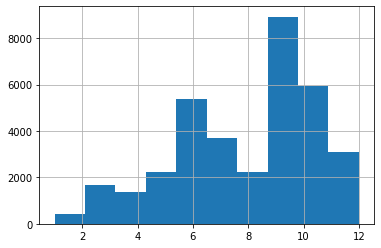

In [237]:
urban_score.hist()

""" Outpu urban score """
urban_score.to_csv('../data/koseki-data-urban_score.csv')

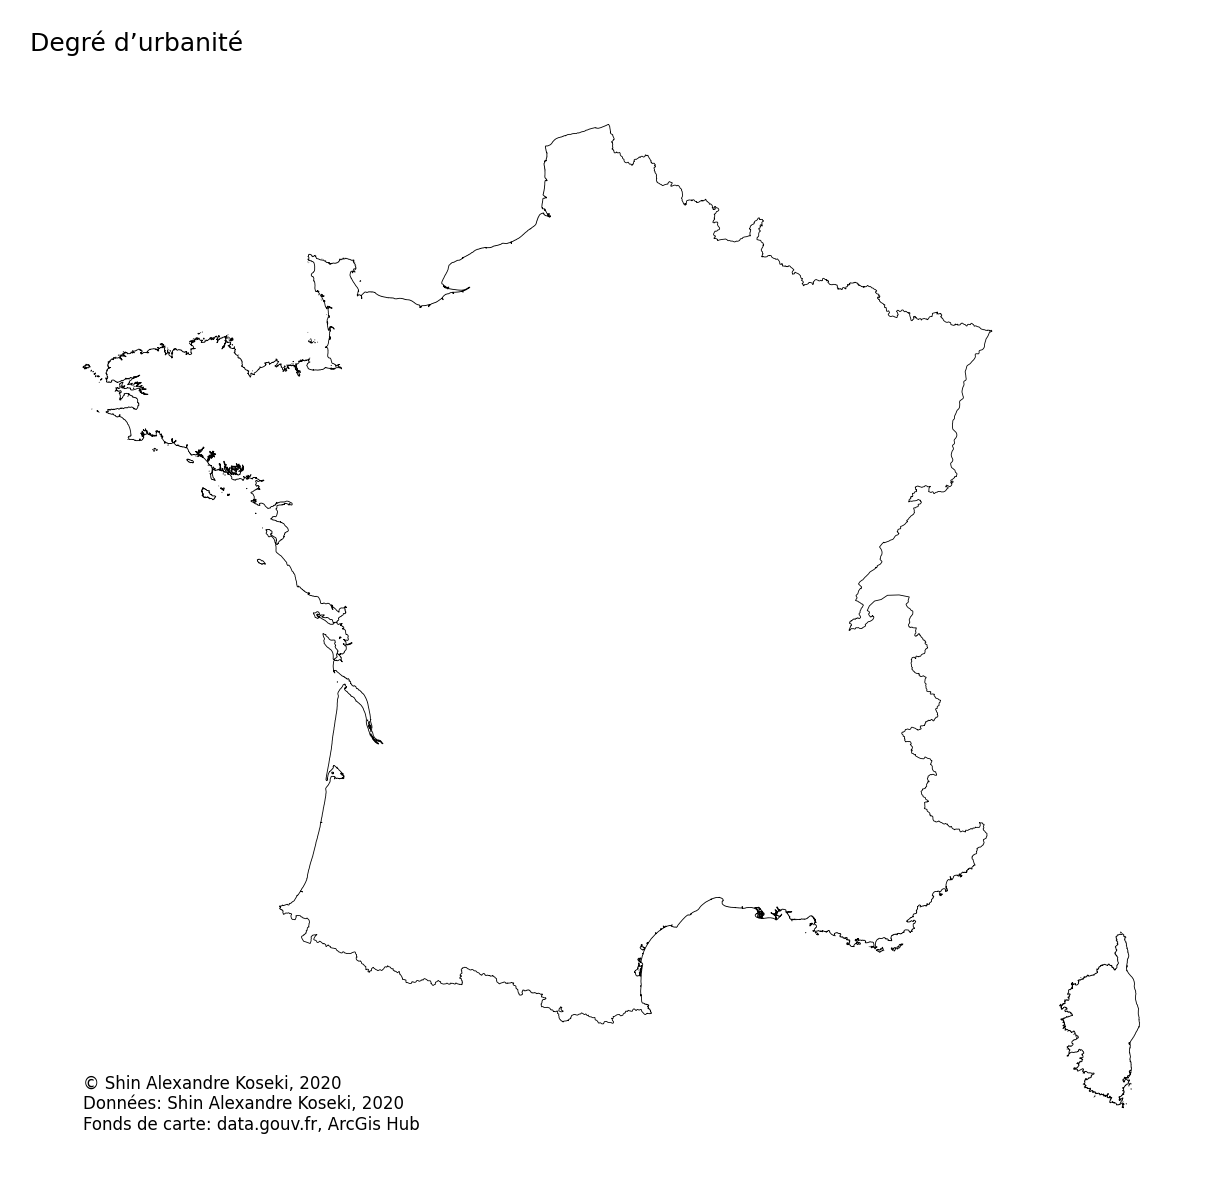

In [238]:
""" Test Plot map info """
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
france.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.2, legend=True)

# Legend
#plt.legend(loc=2, prop={'size': 6})

# Title
plt.title("Degré d’urbanité", fontsize=6, loc='left')

# Notes
s = """
© Shin Alexandre Koseki, 2020
Données: Shin Alexandre Koseki, 2020
Fonds de carte: data.gouv.fr, ArcGis Hub
"""
ax.text(x=99047.004614, y=6000000, s=s, fontsize=4)


ax.axis('off')
plt.show()

# 5 — Benchmark

In this section, we benchmark our measure of urbanity against other institutional or conceptual measures:
* INSEE Tranches en aires urbaines
* INSEE Zones en aires urbaines
* INSEE new measure (ask JL)
* Population density
* Building density

To benchmark these different measures, we look at how they concentrate socioprofessional activities from the *CS1_8* variable, which classify socioprofessional activities in 8 categories.

To illustrate the benchmarking, we plot heatmaps, in which the $x$ axis represent the 8 categories of the *CS1_8* variable, and the $y$ axis represents the classification of each measure of urbanity.

In [67]:
""" Sum people by socioeconomic classes in each municipality """
socioeconomic_count = muni_pop.groupby(['CODGEO', 'CS1_8'])['NB'].sum().reset_index()
socioeconomic_count.head()

CODGEO CS1_8     NB
0  01001     1   15.0
1  01001     2   20.0
2  01001     3   75.0
3  01001     4   95.0
4  01001     5  100.0

## 5.1 — Share of socioeconomic categories by urban area zone (*Zonage en aire urbaine*)

In [286]:
""" Get full labels for urban area zones """
f = '../data/koseki-data-urban_area_zones_labels-200523.csv'
urban_zones_labels = pd.read_csv(f, index_col=0).to_dict()['label']

In [294]:
""" Plot log distribution of municipalties by zone """
### TO DO
zones_municipalities_count = ua_communes['CATAEU2010'].value_counts().sort_index()
data = zones_municipalities_count.values
labels = [urban_zones_labels[x] for x in zones_municipalities_count.index]
labels = [x.replace(' ', '\n') for x in labels]

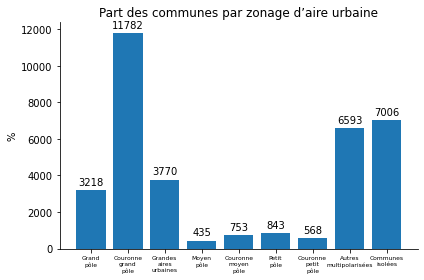

In [295]:
# Convert values to percentage integers
#data = (data / sum(data)) * 100

# Round data
data = [int(round(x)) for x in data]


# Plot share of municipalities
labels = labels
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
rects = ax.bar(x, data, width)

ax.set_ylabel('%')
ax.set_title("Part des communes par zonage d’aire urbaine")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

In [313]:
""" Plot log distributzion of population by zone """
### TO DO
zones_popsize = pd.concat([ua_communes.set_index('CODGEO')['CATAEU2010'], muni_pop.groupby('CODGEO')['NB'].sum()], axis=1).groupby('CATAEU2010')['NB'].sum()
data = zones_popsize.values
labels = [urban_zones_labels[x] for x in zones_popsize.index]
labels = [x.replace(' ', '\n') for x in labels]

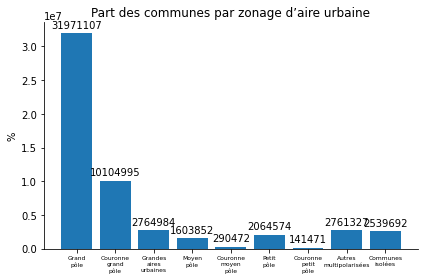

In [311]:
# Round data
data = [int(round(x)) for x in data]


# Plot share of municipalities
labels = labels
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
rects = ax.bar(x, data, width)

ax.set_ylabel('%')
ax.set_title("Population des zonages en aires urbaines")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

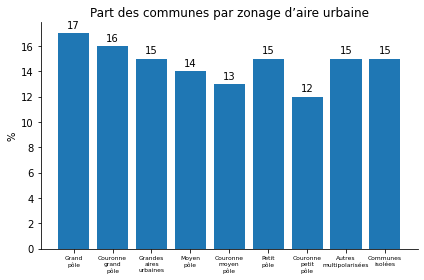

In [312]:
""" Plot Log population """

# Round data
data = np.log(data)
data = [int(round(x)) for x in data]


# Plot share of municipalities
labels = labels
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
rects = ax.bar(x, data, width)

ax.set_ylabel('%')
ax.set_title("Log de la population des zonages en aires urbaines")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

In [77]:
""" Share of sociopressional categories by urban area zone """
# Group municipality by urban area zone
uaz_munis = ua_communes.groupby('CATAEU2010')['CODGEO'].apply(list).to_dict()
## OBSOLETE Count pop by cs1 categories
## OBSOLETE population_by_cs1 = socioeconomic_count.groupby('CS1_8')['NB'].sum()

# Count share of of socioprofessional category by urban area zone
uaz_socioeconomic_share_by_category = {}
for category in uaz_munis.keys():
    uaz_socioeconomic_count = socioeconomic_count[socioeconomic_count['CODGEO'].isin(uaz_munis[category])]
    uaz_population = uaz_socioeconomic_count['NB'].sum()
    uaz_socioeconomic_share = uaz_socioeconomic_count.groupby('CS1_8')['NB'].sum() / uaz_population
    uaz_socioeconomic_share_by_category[category] = uaz_socioeconomic_share

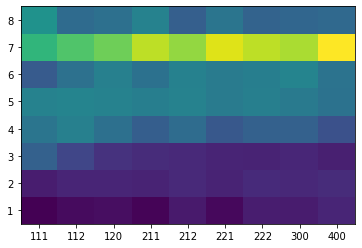

In [78]:
""" Plot share of socioprofessional composition of each urban area zone """
df = pd.DataFrame(uaz_socioeconomic_share_by_category)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

## 5.2 — Share of socioeconomic categories by urban area rank (*Tranches d’aires urbaines*)

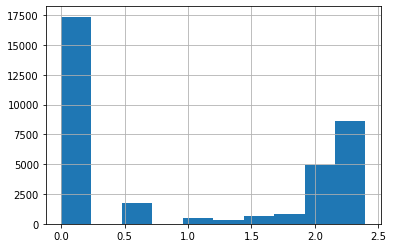

In [131]:
""" Plot log distribution of municipalties by ranks """
np.log(ua_communes.set_index('CODGEO')['AU2010'].replace(urban_areas.set_index('AU2010')['TAU2017'])+1).hist()

In [ ]:
""" Plot log distribution of population by ranks """
### TO DO
ranks_popsize = pd.concat([ua_communes.set_index('CODGEO')['CATAEU2010'], muni_pop.groupby('CODGEO')['NB'].sum()], axis=1).groupby('CATAEU2010')['NB'].sum()
data = zones_popsize.values
labels = [urban_zones_labels[x] for x in zones_popsize.index]
labels = [x.replace(' ', '\n') for x in labels]



In [124]:
""" Share of sociopressional categories by urban area rank """
# Group municipality by urban area rank
uar_munis = ua_communes.set_index('CODGEO')['AU2010'].replace(urban_areas.set_index('AU2010')['TAU2017'].to_dict()).reset_index().groupby('AU2010')['CODGEO'].apply(list).to_dict()

# Count share of of socioprofessional category by urban area zone
uar_socioeconomic_share_by_category = {}
for category in uar_munis.keys():
    uar_socioeconomic_count = socioeconomic_count[socioeconomic_count['CODGEO'].isin(uar_munis[category])]
    uar_population = uar_socioeconomic_count['NB'].sum()
    uar_socioeconomic_share = uar_socioeconomic_count.groupby('CS1_8')['NB'].sum() / uar_population
    uar_socioeconomic_share_by_category[category] = uar_socioeconomic_share

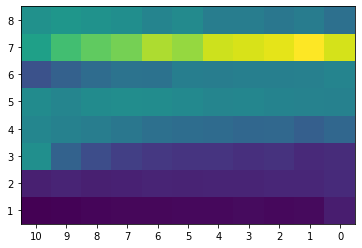

In [120]:
""" Plot share of socioprofessional composition of each urban area ranks """
df = pd.DataFrame(uar_socioeconomic_share_by_category)

# Reverse column order to get the largest ranks on the left
df = df[df.columns[::-1]]

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

## 5.3 — Share socioeconomic categories by population density

In [121]:
""" Compute population density by municpality """
muni_pop.head()
municipal_areas = communes.area / 1000000 # convert sq.m to sq.km
municipal_areas.name = 'area'
municipal_areas.index = communes['CODE']
municipal_densities = muni_pop_sum.divide(municipal_areas)

In [122]:
muni_densities_log = np.log(municipal_densities[municipal_densities!=0].dropna())
muni_densities_log_pos = muni_densities_log + np.abs(muni_densities_log.min())

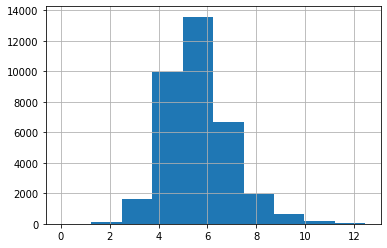

In [123]:
muni_densities_log_pos.hist()

In [ ]:
""" Plot distribution of municipalities by quantiles """
### TO DO 





In [75]:
municipal_density_quantiles = pd.qcut(muni_densities_log_pos, 10).reset_index().groupby(0)['index'].apply(list).to_dict()

In [76]:
quantile_socioeconomic_share_by_quantile = {}
for quantile in municipal_density_quantiles.keys():
    municipalities = municipal_density_quantiles[quantile]
    quantile_socioeconomic_count = socioeconomic_count[socioeconomic_count['CODGEO'].isin(municipalities)]
    quantile_population = quantile_socioeconomic_count['NB'].sum()
    quantile_socioeconomic_share = quantile_socioeconomic_count.groupby('CS1_8')['NB'].sum() / quantile_population
    quantile_socioeconomic_share_by_quantile[quantile] = quantile_socioeconomic_share

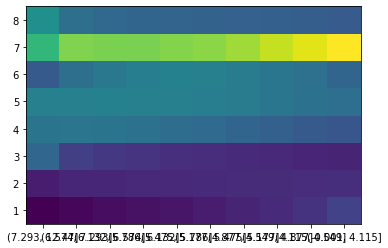

In [115]:
""" Plot share of socioprofessional composition of each population density quantile """
df = pd.DataFrame(quantile_socioeconomic_share_by_quantile)

# Reverse column order to get most density quartiles on the left end
df = df[df.columns[::-1]]

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

## 5.4 — Share socioeconomic categories by urbanity index

In [82]:
""" Input urban score (output fro this notebook) """
f = '../data/koseki-data-urban_score.csv'
urban_score = pd.read_csv(f)
urban_score.columns = ['CODGEO', 'urban_score']
urban_score.head()

CODGEO  urban_score
0  01001          9.0
1  01002          4.0
2  01004          4.0
3  01005          4.0
4  01006          9.0

In [89]:
""" Group municipality by urban score """
urban_score_municipalities = urban_score.groupby('urban_score')['CODGEO'].apply(list).to_dict()

score_socioeconomic_share_by_score = {}
for score in urban_score_municipalities:
    municipalities = urban_score_municipalities[score]
    score_socioeconomic_count = socioeconomic_count[socioeconomic_count['CODGEO'].isin(municipalities)]
    score_population = score_socioeconomic_count['NB'].sum()
    score_socioeconomic_share = score_socioeconomic_count.groupby('CS1_8')['NB'].sum() / score_population
    score_socioeconomic_share_by_score[score] = score_socioeconomic_share

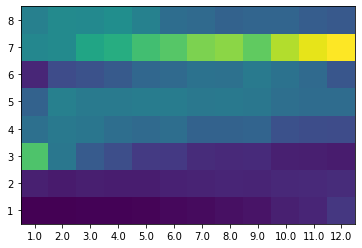

In [90]:
""" Plot share of socioprofessional composition of each urban score """
df = pd.DataFrame(score_socioeconomic_share_by_score)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()